# Caml API Usage

In [1]:
import os
import sys

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

datasets = [
    "partially_linear_simple",
    "fully_heterogenous",
    "partially_linear_constant",
    "dowhy_linear",
]
backends = ["pandas", "pyspark", "polars"]

df_backend = backends[0]
dataset = datasets[1]

## Synthetic Data

In [2]:
from caml.extensions.synthetic_data import (
    make_partially_linear_dataset_simple,
    make_fully_heterogeneous_dataset,
    make_partially_linear_dataset_constant,
    make_dowhy_linear_dataset,
)

if dataset == "partially_linear_simple":
    df, true_cates, true_ate = make_partially_linear_dataset_simple(
        n_obs=5000,
        n_confounders=5,
        dim_heterogeneity=2,
        binary_treatment=True,
        seed=None,
    )
    df["true_cates"] = true_cates
elif dataset == "fully_heterogenous":
    df, true_cates, true_ate = make_fully_heterogeneous_dataset(
        n_obs=5000000,
        n_confounders=50,
        theta=4.0,
        seed=None,
    )
    df["true_cates"] = true_cates
elif dataset == "partially_linear_constant":
    df, true_cates, true_ate = make_partially_linear_dataset_constant(
        n_obs=5000,
        ate=4.0,
        n_confounders=5,
        dgp="make_plr_CCDDHNR2018",  # make_plr_turrell2018
        seed=None,
    )
    df["true_cates"] = true_cates
elif dataset == "dowhy_linear":
    df, true_cates, true_ate = make_dowhy_linear_dataset(
        beta=2.0,
        n_obs=10_000,
        n_confounders=10,
        n_discrete_confounders=3,
        n_effect_modifiers=10,
        n_discrete_effect_modifiers=3,
        n_treatments=1,
        binary_treatment=True,
        categorical_treatment=False,
        binary_outcome=False,
        seed=12,
    )

    for i in range(1, len(true_cates) + 1):
        if isinstance(true_cates[f"d{i}"], list):
            df[f"true_cate_d{i}_1"] = true_cates[f"d{i}"][0]
            df[f"true_cate_d{i}_2"] = true_cates[f"d{i}"][1]
        else:
            df[f"true_cate_d{i}"] = true_cates[f"d{i}"]


df["uuid"] = df.index

In [3]:
try:
    import polars as pl
    from pyspark.sql import SparkSession
except ImportError:
    pass

if df_backend == "polars":
    df = pl.from_pandas(df)
    spark = None
elif df_backend == "pandas":
    spark = None
    pass
elif df_backend == "pyspark":
    spark = (
        SparkSession.builder.master("local[1]")
        .appName("local-tests")
        .config("spark.executor.cores", "1")
        .config("spark.executor.instances", "1")
        .config("spark.sql.shuffle.partitions", "1")
        .getOrCreate()
    )
    df = spark.createDataFrame(df)

In [4]:
df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X45,X46,X47,X48,X49,X50,y,d,true_cates,uuid
0,0.745401,0.996627,-1.120130,-2.533084,-0.819423,-1.023338,-1.535904,-1.461482,-1.813358,-1.162655,...,-0.502097,-0.380823,0.907127,-0.361621,-1.012564,-0.462052,1.954563,0.0,4.485037,0
1,-1.683839,-1.235498,0.424483,-0.483820,0.715273,-0.466479,0.597045,0.452037,-0.192989,-1.764756,...,-1.619976,-0.473223,-1.306333,-1.262764,-1.182884,0.712351,-0.138680,0.0,2.353113,1
2,-0.163029,-0.266897,-0.111722,-1.132490,-2.296262,-1.075063,-0.632954,0.584092,0.810897,0.501975,...,0.963071,1.264844,0.686352,1.582092,0.701994,0.833409,-0.662317,0.0,3.662954,2
3,0.353236,1.714588,1.283875,0.105592,1.621584,-0.369131,0.898459,0.526544,-0.212289,-0.531261,...,-1.396960,-1.080415,-0.766222,-2.105540,-1.450801,-1.124487,3.663826,1.0,4.794406,3
4,0.399406,-0.389049,0.288845,0.537523,0.253748,-0.801299,-0.829448,-0.652200,0.542835,-0.022350,...,0.464367,-0.264685,-0.241262,-0.181282,0.126418,0.043087,4.862445,1.0,4.290382,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,-0.454115,-1.304605,0.035111,-0.762234,-0.713039,-0.397512,0.454479,-0.320811,-1.159273,-0.521318,...,-0.038793,-0.253865,-0.237416,0.694779,-0.361436,0.229217,0.245886,0.0,3.289057,4999995
4999996,-0.553082,-1.412586,-0.632279,0.245796,0.746889,0.706904,0.359374,0.957347,1.695609,0.800420,...,-0.202590,-0.198142,-2.123670,-0.856373,-1.596041,0.209194,0.078493,0.0,3.297985,4999996
4999997,-0.791689,-2.344839,-1.565968,0.900899,-0.557887,0.099783,-0.466164,-0.922788,0.813559,-0.046291,...,-1.297521,-0.886526,-0.235497,1.698667,0.956510,0.282271,4.274264,1.0,2.766262,4999997
4999998,-0.273220,-0.388728,-0.211480,-0.893047,0.087843,1.028880,1.663535,0.309936,1.112627,1.611111,...,-0.177354,0.087037,0.434963,-0.141240,0.330656,-1.077168,6.060158,1.0,3.688975,4999998


## Core API

### CamlCATE

#### Class Instantiation

In [8]:
from caml import CamlCATE

caml = CamlCATE(
    df=df,
    Y="y",
    T="d",
    X=[c for c in df.columns if "X" in c] + [c for c in df.columns if "W" in c],
    uuid="uuid",
    discrete_treatment=True,
    discrete_outcome=False,
    seed=0,
    verbose=1,
)

[11/08/24 19:54:53] INFO     Logging has been set up.                                                 ]8;id=726663;file:///config/workspace/caml/caml/logging.py\logging.py]8;;\:]8;id=408802;file:///config/workspace/caml/caml/logging.py#51\51]8;;\

In [9]:
print(caml)

================== CamlCATE Object ==================
Data Backend: pandas
No. of Observations: 5000
UUID: uuid
Outcome Variable: y
Discrete Outcome: False
Treatment Variable: d
Discrete Treatment: True
Features/Confounders: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50']
Random Seed: 0



#### Nuissance Function AutoML

In [10]:
caml.auto_nuisance_functions(
    flaml_Y_kwargs={"time_budget": 30},
    flaml_T_kwargs={"time_budget": 30},
    use_ray=False,
    use_spark=False,
)

[flaml.automl.logger: 11-08 19:55:03] {1680} INFO - task = regression
[flaml.automl.logger: 11-08 19:55:03] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 11-08 19:55:03] {1789} INFO - Minimizing error metric: mse
[flaml.automl.logger: 11-08 19:55:03] {1901} INFO - List of ML learners in AutoML Run: ['rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.logger: 11-08 19:55:03] {2219} INFO - iteration 0, current learner rf
[flaml.automl.logger: 11-08 19:55:03] {2345} INFO - Estimated sufficient time budget=2084s. Estimated necessary time budget=7s.
[flaml.automl.logger: 11-08 19:55:03] {2392} INFO -  at 0.2s,	estimator rf's best error=3.9808,	best estimator rf's best error=3.9808
[flaml.automl.logger: 11-08 19:55:03] {2219} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 11-08 19:55:06] {2392} INFO -  at 2.8s,	estimator xgboost's best error=5.1244,	best estimator rf's best error=3.9808
[flaml.automl.logger: 11-08 19:55:06] {2219} INFO - iteration 2,

KeyboardInterrupt: 

#### Fit and ensemble CATE models

In [8]:
caml.fit_validator(
    subset_cate_models=[
        "LinearDML",
        "CausalForestDML",
        "NonParamDML",
        # "AutoNonParamDML",
        # "SparseLinearDML-2D",
        "DRLearner",
        "ForestDRLearner",
        "LinearDRLearner",
        # "SparseLinearDRLearner-2D",
        "DomainAdaptationLearner",
        "SLearner",
        "TLearner",
        "XLearner"
    ],
    rscorer_kwargs={},
    use_ray=False,
    ray_remote_func_options_kwargs={},
    sample_fraction=1.0,
    n_jobs=-1,
)

Pass `sample_weight` as keyword args.


[09/23/24 22:42:27] INFO     Ensemble Estimator RScore: 0.09280211785851877                             ]8;id=411908;file:///caml/caml/core/cate.py\cate.py]8;;\:]8;id=659108;file:///caml/caml/core/cate.py#925\925]8;;\

                    INFO     Inidividual Estimator RScores: {'LinearDML': 0.09279550941725478,          ]8;id=717066;file:///caml/caml/core/cate.py\cate.py]8;;\:]8;id=962597;file:///caml/caml/core/cate.py#926\926]8;;\
                             'CausalForestDML': 0.06832216065714991, 'NonParamDML': 0.0714174708555122,            
                             'DRLearner': 0.0694533173847367, 'ForestDRLearner': 0.07193994467614262,              
                             'LinearDRLearner': 0.08708014673593067, 'DomainAdaptationLearner':                    
                             0.08273628378343745, 'SLearner': 0.06918585857879733, 'TLearner':                     
                             0.08252324506070485, 'XLearner': 0.06962327727286566}                                 

                    INFO     The ensemble estimator is the best estimator, filtering out models with    ]8;id=582184;file:///caml/caml/core/cate.py\cate.py]8;;\:]8;id=705419;file:///caml/caml/core/cate.py#942\942]8;;\
                             weights less than 0.01.                                                               

In [9]:
caml.validation_estimator

[09/23/24 22:42:28] INFO     The validation estimator has been fit and will be returned.                ]8;id=769182;file:///caml/caml/core/_base.py\_base.py]8;;\:]8;id=475269;file:///caml/caml/core/_base.py#55\55]8;;\

#### CATE Validation

[09/23/24 22:42:32] INFO     All validation results suggest that the model has found statistically      ]8;id=822482;file:///caml/caml/core/cate.py\cate.py]8;;\:]8;id=226279;file:///caml/caml/core/cate.py#495\495]8;;\
                             significant heterogeneity.                                                            

   treatment  blp_est  blp_se  blp_pval  qini_est  qini_se  qini_pval  autoc_est  autoc_se  autoc_pval  cal_r_squared
0          1    0.849   0.017       0.0     0.852    0.027        0.0      2.376     0.089         0.0           0.37


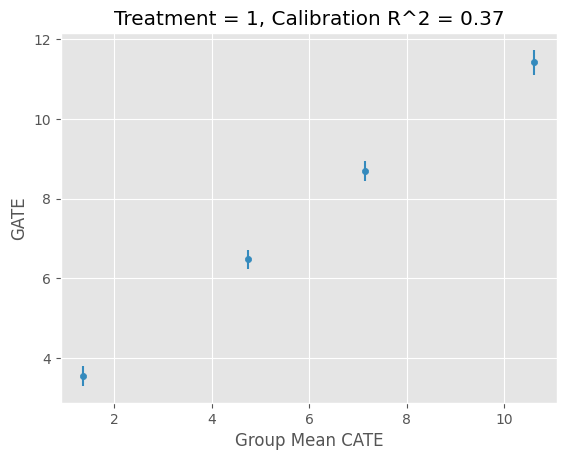

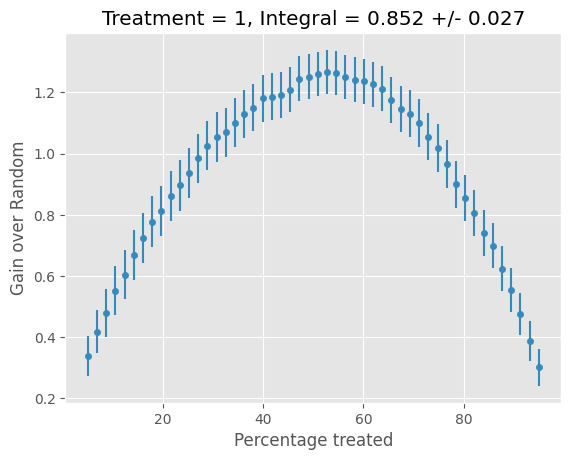

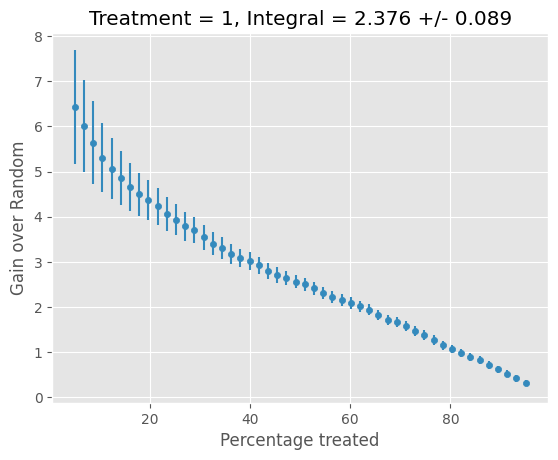

In [10]:
validation_results = caml.validate(n_groups=4,n_bootstrap=1000,print_full_report=True)

#### Refit best estimator on full dataset

In [11]:
caml.fit_final()

In [12]:
caml.final_estimator

[09/23/24 22:42:35] INFO     The final estimator has been fit on the entire dataset and will be         ]8;id=264533;file:///caml/caml/core/_base.py\_base.py]8;;\:]8;id=852786;file:///caml/caml/core/_base.py#65\65]8;;\
                             returned.                                                                             

#### Predict CATEs

In [13]:
## "Out of sample" predictions

df_predictions = caml.predict(
    out_of_sample_df=df,
    out_of_sample_uuid="uuid",
    return_predictions=False,
    join_predictions=True,
)

if df_backend == "pyspark":
    df_predictions.show()
else:
    print(df_predictions)

            X0        X1        X2        X3        X4        X5        X6  \
0     0.860128  1.263800 -1.621480 -1.243014  0.119318  0.138299 -2.190976   
1     0.085828 -0.258028  0.648743 -1.045765 -0.128647  0.435518  0.108749   
2     1.077397 -0.389245  0.503995 -1.182757 -1.419884  1.466198 -1.111965   
3     1.864333  0.424140  0.705238  1.087511 -0.978616  1.553906 -1.056368   
4     0.042030 -2.178140  0.773407 -1.260931  0.600929  0.659652 -0.311650   
...        ...       ...       ...       ...       ...       ...       ...   
9995  1.173214  1.718103  0.527236 -0.833312  0.857061 -0.963238 -0.802704   
9996  0.916397  0.691821  0.512401 -0.098800 -0.721480  0.789828  0.042103   
9997  3.512478 -0.894800  1.119166 -1.482994 -1.278946 -0.029847 -0.221000   
9998  0.615903  1.969203  0.407985  0.945009  0.580888  0.783290 -1.168335   
9999  0.858440  0.199468  1.723768 -1.405161 -0.082894 -1.798955 -1.702678   

      X7  X8  X9  ...        W5        W6  W7  W8  W9     d1   

In [14]:
caml._Y.execute().shape[1]

1

In [15]:
## Append to internal dataframe

caml.predict(
    out_of_sample_df=None,
    out_of_sample_uuid=None,
    join_predictions=True,
    return_predictions=False,
)

caml.dataframe

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,W5,W6,W7,W8,W9,d1,y,true_cate_d1,uuid,cate_predictions_1
0,0.860128,1.263800,-1.621480,-1.243014,0.119318,0.138299,-2.190976,3,0,2,...,3.709313,0.203607,2,3,0,True,4.197980,0.793035,0,0.451573
1,0.085828,-0.258028,0.648743,-1.045765,-0.128647,0.435518,0.108749,3,0,2,...,2.047290,1.303302,2,2,2,True,8.774372,5.340261,1,4.142079
2,1.077397,-0.389245,0.503995,-1.182757,-1.419884,1.466198,-1.111965,3,3,2,...,0.190063,0.273025,1,2,1,False,-6.610495,7.983276,2,9.677588
3,1.864333,0.424140,0.705238,1.087511,-0.978616,1.553906,-1.056368,1,3,0,...,0.159549,0.229549,1,3,2,True,8.211690,10.040109,3,9.572106
4,0.042030,-2.178140,0.773407,-1.260931,0.600929,0.659652,-0.311650,0,3,0,...,1.372630,1.033920,3,0,3,True,3.598249,4.030683,4,3.436651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.173214,1.718103,0.527236,-0.833312,0.857061,-0.963238,-0.802704,0,2,2,...,0.877547,0.160547,0,1,1,True,10.896206,6.942622,9995,6.468450
9996,0.916397,0.691821,0.512401,-0.098800,-0.721480,0.789828,0.042103,2,2,2,...,-0.574287,2.923056,2,2,1,True,10.268397,9.750975,9996,8.414832
9997,3.512478,-0.894800,1.119166,-1.482994,-1.278946,-0.029847,-0.221000,3,3,2,...,1.961363,0.020335,2,1,2,True,11.488667,11.082038,9997,11.240483
9998,0.615903,1.969203,0.407985,0.945009,0.580888,0.783290,-1.168335,1,3,2,...,1.078907,1.013377,2,0,3,True,12.162188,11.152002,9998,10.892183


#### CATE Rank Ordering

In [16]:
caml._data_splits['X_test']

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9
9394,1.243233,0.439330,2.268630,-0.255971,-1.715445,-0.478830,0.071265,0,2,3,0.788381,2.386654,0.363269,0.750297,-2.170613,-0.584423,1.653364,3,3,0
898,1.675701,0.742179,0.312525,-0.411042,-0.692390,-1.449291,-1.125768,3,3,3,-1.112780,-1.254853,-1.946457,0.619481,-1.961030,1.214482,1.111170,3,0,2
2398,2.636894,-0.298611,1.344434,-0.318055,-0.261962,-0.169126,-0.569835,0,3,3,-1.664668,1.006795,-1.326931,1.051268,-2.288011,-0.704618,0.080985,2,1,1
5906,-0.161661,2.354351,0.858336,-1.923047,0.911348,-1.274692,-0.810877,1,0,0,-1.783143,0.878185,-1.329807,-0.549843,-1.275947,-0.796126,0.720818,0,0,3
2343,1.234587,0.011620,-0.006270,-0.908755,-1.187897,-0.291652,-0.280598,3,3,2,0.371592,2.618933,-0.150930,0.727381,0.449713,1.356611,0.017148,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,3.177082,1.276854,1.586237,-0.491319,0.153824,-0.046903,-1.895296,3,1,0,-0.853366,0.230630,-0.423872,0.861986,-2.205145,1.580122,0.320876,2,3,3
2899,0.664205,-0.801088,0.419685,1.015579,1.438343,0.045251,0.021715,3,0,1,-1.837015,0.215833,-1.316201,-0.641182,0.957291,1.137492,1.528655,2,2,2
9549,-0.632450,2.510527,-0.267888,-0.207241,2.564845,-1.031361,1.214053,2,3,0,-0.452604,0.536116,0.653066,0.136701,-1.415378,0.754262,2.207488,1,2,3
2740,-1.322408,-1.249239,1.068768,0.441756,0.647362,1.087716,-0.350724,0,1,3,-0.663683,-0.067110,-0.475977,0.148028,-1.942542,1.275418,0.313948,0,3,1


In [17]:
## "Out of sample" predictions

df_rank_ordered = caml.rank_order(
    out_of_sample_df=df_predictions,
    return_rank_order=False,
    join_rank_order=True,
    treatment_category=1,
)

df_rank_ordered

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,W6,W7,W8,W9,d1,y,true_cate_d1,uuid,cate_predictions_1,cate_ranking
0,0.814376,0.944291,2.507192,0.066029,1.700093,2.400939,0.108949,3,3,3,...,-0.451147,1,0,1,True,15.948942,18.116305,7075,19.406075,0
1,3.836901,0.082046,2.550175,-1.421080,2.174478,0.161377,-0.369003,3,2,3,...,1.186787,0,0,0,False,-1.069935,15.910476,5105,18.136283,1
2,1.457376,1.055202,2.328859,0.032418,1.829073,0.692704,1.798837,0,2,3,...,0.349671,2,0,2,True,19.348316,17.280477,9286,17.912410,2
3,2.066875,1.259132,2.592634,0.161854,0.595246,0.931347,1.277771,1,1,3,...,0.032749,3,0,1,False,-2.233363,16.634338,3259,17.693081,3
4,1.777121,1.326565,1.540720,-0.563575,0.012335,1.479376,1.448806,3,3,3,...,2.419116,1,0,0,True,21.018672,17.535930,879,17.515142,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.102649,0.029844,-1.745730,-1.590462,-0.603697,-0.936488,-0.820108,1,0,0,...,1.355290,2,3,2,True,0.596561,-4.092957,4057,-6.273791,9995
9996,-0.790502,-0.525861,-1.386381,-2.115021,-0.784225,-0.785612,-1.464777,1,1,1,...,0.833533,3,2,3,True,-4.031012,-4.399581,6906,-6.285389,9996
9997,-0.542512,-0.299324,0.780758,-2.017447,0.282860,-1.170741,-3.350026,0,0,0,...,0.939172,2,0,1,True,-5.421809,-6.397640,2412,-6.307648,9997
9998,0.139289,0.550178,-0.927531,-1.004718,0.249963,-2.864877,-2.970037,2,1,0,...,0.696058,3,3,3,True,-1.110671,-4.798014,972,-6.599571,9998


In [18]:
## Append to internal dataframe

caml.rank_order(
    out_of_sample_df=None,
    return_rank_order=False,
    join_rank_order=True,
    treatment_category=1,
)

caml.dataframe

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,W6,W7,W8,W9,d1,y,true_cate_d1,uuid,cate_predictions_1,cate_ranking
0,0.814376,0.944291,2.507192,0.066029,1.700093,2.400939,0.108949,3,3,3,...,-0.451147,1,0,1,True,15.948942,18.116305,7075,19.406075,0
1,3.836901,0.082046,2.550175,-1.421080,2.174478,0.161377,-0.369003,3,2,3,...,1.186787,0,0,0,False,-1.069935,15.910476,5105,18.136283,1
2,1.457376,1.055202,2.328859,0.032418,1.829073,0.692704,1.798837,0,2,3,...,0.349671,2,0,2,True,19.348316,17.280477,9286,17.912410,2
3,2.066875,1.259132,2.592634,0.161854,0.595246,0.931347,1.277771,1,1,3,...,0.032749,3,0,1,False,-2.233363,16.634338,3259,17.693081,3
4,1.777121,1.326565,1.540720,-0.563575,0.012335,1.479376,1.448806,3,3,3,...,2.419116,1,0,0,True,21.018672,17.535930,879,17.515142,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.102649,0.029844,-1.745730,-1.590462,-0.603697,-0.936488,-0.820108,1,0,0,...,1.355290,2,3,2,True,0.596561,-4.092957,4057,-6.273791,9995
9996,-0.790502,-0.525861,-1.386381,-2.115021,-0.784225,-0.785612,-1.464777,1,1,1,...,0.833533,3,2,3,True,-4.031012,-4.399581,6906,-6.285389,9996
9997,-0.542512,-0.299324,0.780758,-2.017447,0.282860,-1.170741,-3.350026,0,0,0,...,0.939172,2,0,1,True,-5.421809,-6.397640,2412,-6.307648,9997
9998,0.139289,0.550178,-0.927531,-1.004718,0.249963,-2.864877,-2.970037,2,1,0,...,0.696058,3,3,3,True,-1.110671,-4.798014,972,-6.599571,9998


#### CATE Visualization/Summary

In [19]:
cate_summary = caml.summarize(out_of_sample_df=df_rank_ordered, treatment_category=1)

cate_summary

,cate_mean,cate_sum,cate_std,cate_min,cate_max,count
0,6.07798,60779.804057,3.654338,-6.84237,19.406075,10000


In [20]:
cate_summary = caml.summarize(out_of_sample_df=None, treatment_category=1)

cate_summary

,cate_mean,cate_sum,cate_std,cate_min,cate_max,count
0,6.07798,60779.804057,3.654338,-6.84237,19.406075,10000


In [21]:
true_ate

{'d1': 6.458307175849255}

#### Access my dataframe, estimator object, and get string representation of class

In [22]:
caml.dataframe

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,W6,W7,W8,W9,d1,y,true_cate_d1,uuid,cate_predictions_1,cate_ranking
0,0.814376,0.944291,2.507192,0.066029,1.700093,2.400939,0.108949,3,3,3,...,-0.451147,1,0,1,True,15.948942,18.116305,7075,19.406075,0
1,3.836901,0.082046,2.550175,-1.421080,2.174478,0.161377,-0.369003,3,2,3,...,1.186787,0,0,0,False,-1.069935,15.910476,5105,18.136283,1
2,1.457376,1.055202,2.328859,0.032418,1.829073,0.692704,1.798837,0,2,3,...,0.349671,2,0,2,True,19.348316,17.280477,9286,17.912410,2
3,2.066875,1.259132,2.592634,0.161854,0.595246,0.931347,1.277771,1,1,3,...,0.032749,3,0,1,False,-2.233363,16.634338,3259,17.693081,3
4,1.777121,1.326565,1.540720,-0.563575,0.012335,1.479376,1.448806,3,3,3,...,2.419116,1,0,0,True,21.018672,17.535930,879,17.515142,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.102649,0.029844,-1.745730,-1.590462,-0.603697,-0.936488,-0.820108,1,0,0,...,1.355290,2,3,2,True,0.596561,-4.092957,4057,-6.273791,9995
9996,-0.790502,-0.525861,-1.386381,-2.115021,-0.784225,-0.785612,-1.464777,1,1,1,...,0.833533,3,2,3,True,-4.031012,-4.399581,6906,-6.285389,9996
9997,-0.542512,-0.299324,0.780758,-2.017447,0.282860,-1.170741,-3.350026,0,0,0,...,0.939172,2,0,1,True,-5.421809,-6.397640,2412,-6.307648,9997
9998,0.139289,0.550178,-0.927531,-1.004718,0.249963,-2.864877,-2.970037,2,1,0,...,0.696058,3,3,3,True,-1.110671,-4.798014,972,-6.599571,9998


In [23]:
from econml.score import EnsembleCateEstimator

# Use this estimator object as pickled object for optimized inference
final_estimator = caml.final_estimator

if isinstance(final_estimator, EnsembleCateEstimator):
    for model in final_estimator._cate_models:
        print(model)
        print(model._input_names)
else:
    print(final_estimator)
    print(final_estimator._input_names)

[09/23/24 22:42:36] INFO     The final estimator has been fit on the entire dataset and will be         ]8;id=698333;file:///caml/caml/core/_base.py\_base.py]8;;\:]8;id=54250;file:///caml/caml/core/_base.py#65\65]8;;\
                             returned.                                                                             

{'feature_names': ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19'], 'output_names': ['Y0'], 'treatment_names': ['T0_True']}


In [24]:
print(caml)

================== CamlCATE Object ==================
Data Backend: pandas
No. of Observations: 10000
UUID: uuid
Outcome Variable: y
Discrete Outcome: False
Treatment Variable: d1
Discrete Treatment: True
Features/Confounders: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'W0', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9']
Random Seed: 0
Nuissance Model Y_X: XGBRegressor(base_score=None, booster=None, callbacks=[],
             colsample_bylevel=0.8186958088814515, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1660009525156934,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=0.6100405713242076, 

# Plots

In [25]:
from caml.extensions.plots import (cate_histogram_plot, 
                                   cate_true_vs_estimated_plot, 
                                   cate_line_plot)

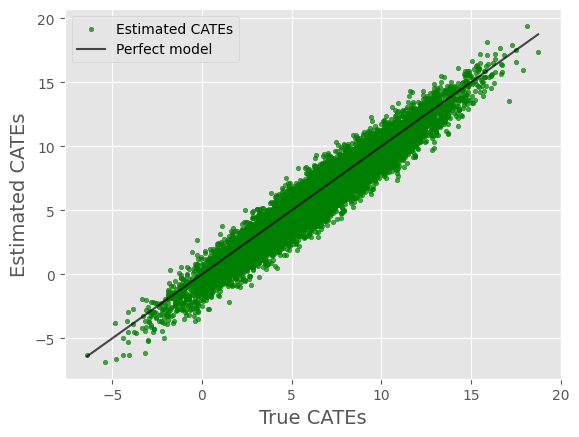

In [26]:
cate_true_vs_estimated_plot(true_cates=caml.dataframe['true_cate_d1'],estimated_cates=caml.dataframe['cate_predictions_1'])

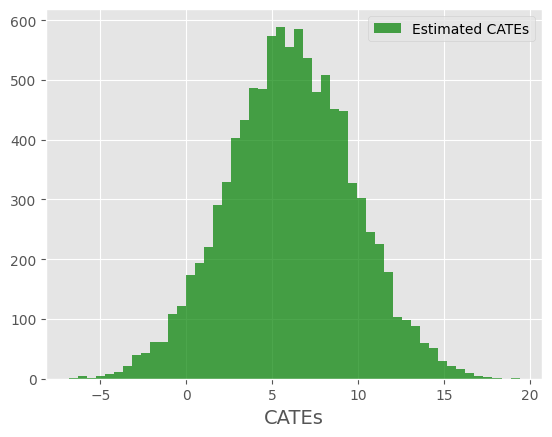

In [27]:
cate_histogram_plot(estimated_cates=caml.dataframe['cate_predictions_1'])

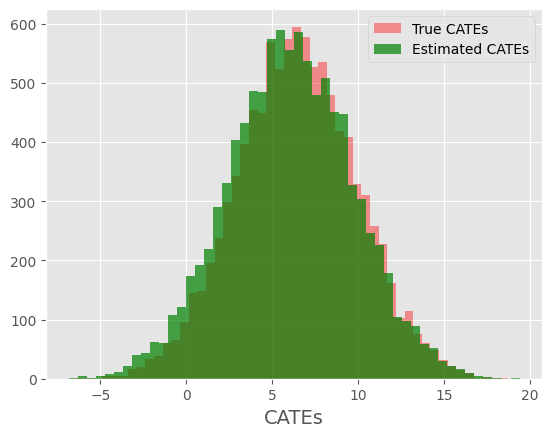

In [28]:
cate_histogram_plot(estimated_cates=caml.dataframe['cate_predictions_1'],true_cates=caml.dataframe['true_cate_d1'])

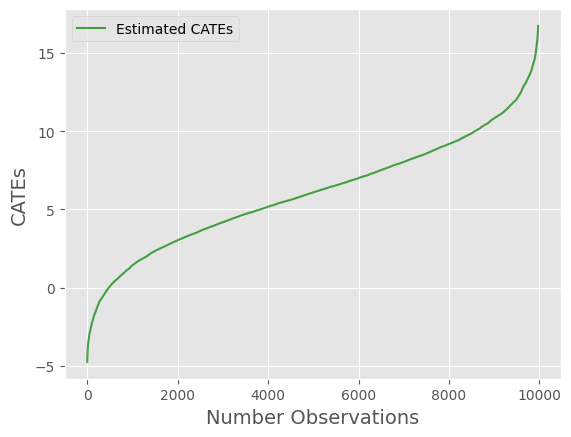

In [29]:
cate_line_plot(estimated_cates=caml.dataframe['cate_predictions_1'],window=30)

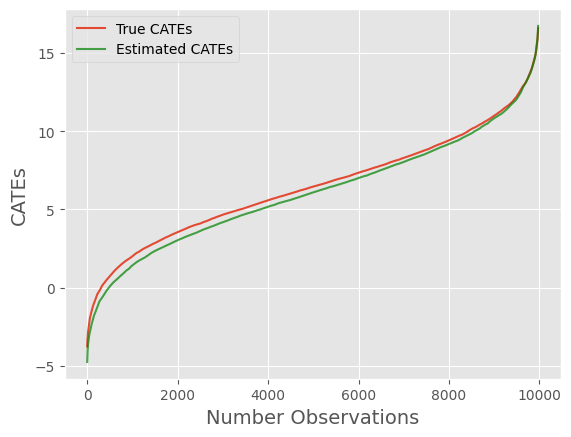

In [30]:
cate_line_plot(estimated_cates=caml.dataframe['cate_predictions_1'],true_cates=caml.dataframe['true_cate_d1'],window=30)